In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sensordata
sns.set_style(style='whitegrid')

datasets, features_sets, target_sets, metadata = sensordata.load_and_preprocess_data(validationset=True, savecsv=False, sensorset='FIS')
calibrationset = datasets[0]
calibration_features_matrix = features_sets[0]
calibration_co_cons = target_sets[0]

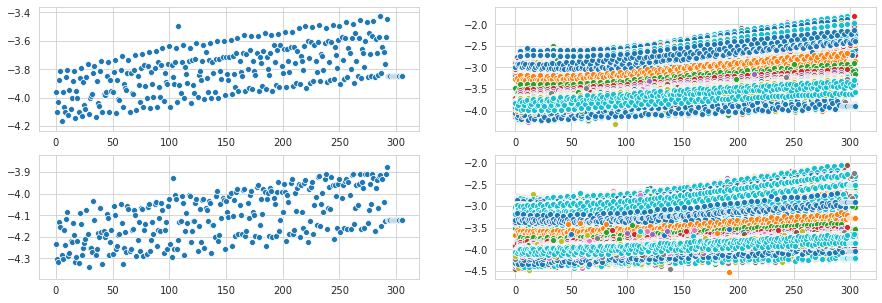

In [14]:
day = 1
fig, axes = plt.subplots(2,2, figsize=(15,5))
signalsample = 1
signalconc = target_sets[day-1][signalsample]
signal = features_sets[day-1][signalsample,:]
nsig = len(signal)
sns.scatterplot(np.arange(nsig),signal, ax=axes[0,0])

signalconcs = target_sets[day-1]
signals = features_sets[day-1]
nsig = len(signals)
for signal in signals[:100]:
    nsig = len(signal)
    sns.scatterplot(np.arange(nsig),signal, ax=axes[0,1])

day = 13
signalsample = 1
signalconc = target_sets[day-1][signalsample]
signal = features_sets[day-1][signalsample,:]
nsig = len(signal)
sns.scatterplot(np.arange(nsig),signal, ax=axes[1,0])

signalconcs = target_sets[day-1]
signals = features_sets[day-1]
nsig = len(signals)
for signal in signals[:100]:
    nsig = len(signal)
    sns.scatterplot(np.arange(nsig),signal, ax=axes[1,1])
plt.show()

### Preparing data

In [35]:
obs = 0
dim = features_sets[0].shape[1]
for set in features_sets:
    obs+=set.shape[0]
features = np.zeros((obs,dim))
target = np.zeros((obs,1))
i = 0
end_obs = 0

for set in range(len(features_sets)):
    start_obs = end_obs
    end_obs += features_sets[set].shape[0]
    features[start_obs:end_obs,:] = features_sets[set]
    target[start_obs:end_obs,:] = target_sets[set]

target = target.reshape(len(target))

features = np.array(pd.DataFrame(features).interpolate(axis=1))
features = np.array(pd.DataFrame(features).interpolate(axis=0))
print(features.shape)
print(target.shape)

data = target
test_ratio = 0.2
shuffled_indices = np.random.permutation(len(data))
test_set_size = int(len(data) * test_ratio)
test_indices = shuffled_indices[:test_set_size]
train_indices = shuffled_indices[test_set_size:]

X_train = features[train_indices]
X_test = features[test_indices]
y_train = target[train_indices]
y_test = target[test_indices]

(52526, 481)
(52526,)


In [34]:
cv_scores_matrix.shape

(19, 57)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection

signals = calibration_features_matrix
targets = calibration_co_cons

X = signals
y = targets.reshape(len(targets))

test_size = 0.2
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

max_leaf_range = np.arange(8, 65)
estimator_range = np.arange(5, 106)
cv_scores_matrix = np.zeros((len(estimator_range),len(max_leaf_range)))
rmse = []
for i in estimator_range:
    for j in max_leaf_range:
        forest_reg = RandomForestRegressor(n_estimators=i, max_leaf_nodes=j, n_jobs=-1, random_state=42)
        score = model_selection.cross_val_score(forest_reg, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()
        rmse.append(np.sqrt(-score))
        
        i_score = i-estimator_range[0]
        j_score = j-max_leaf_range[0]
        cv_scores_matrix[i_score, j_score] = np.sqrt(-score)
        np.savetxt('cv_score.csv',cv_scores_matrix, delimiter=',', fmt='%1.4f')
        print("Number of estimators: " + str(i) + ", number of max_leafs: " + str(j) + ", average CV score: " + str(cv_scores_matrix[i_score, j_score]))

Number of estimators: 5, number of max_leafs: 8, average CV score: 2.6792900263840513
Number of estimators: 5, number of max_leafs: 9, average CV score: 2.6680677593780118
Number of estimators: 5, number of max_leafs: 10, average CV score: 2.6726995462520464
Number of estimators: 5, number of max_leafs: 11, average CV score: 2.6643108612948527
Number of estimators: 5, number of max_leafs: 12, average CV score: 2.661877334945882
Number of estimators: 5, number of max_leafs: 13, average CV score: 2.672066657619957
Number of estimators: 5, number of max_leafs: 14, average CV score: 2.6970764816079247
Number of estimators: 5, number of max_leafs: 15, average CV score: 2.6867698709544747
Number of estimators: 5, number of max_leafs: 16, average CV score: 2.6751616164556515
Number of estimators: 5, number of max_leafs: 17, average CV score: 2.6595848483195854
Number of estimators: 5, number of max_leafs: 18, average CV score: 2.653060310817316
Number of estimators: 5, number of max_leafs: 19

[3.05082772 2.87178868 2.64858031 2.7056352  2.63775031 2.6154865
 2.60610681 2.59063069 2.63284109 2.57953132 2.58512931 2.55472249
 2.58617358 2.56529188 2.57075132 2.56774631 2.52756685 2.5693433
 2.54322754]


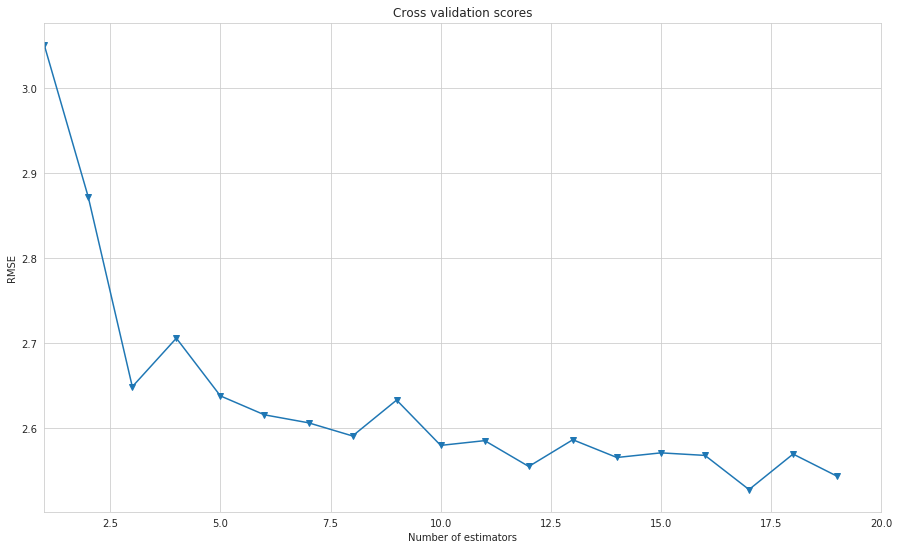

In [15]:
from sklearn.metrics import mean_squared_error

print(np.array(rmse))
plt.figure(figsize=(15,9))
plt.plot(estimator_range, np.array(rmse), '-v')
plt.xlabel('Number of estimators')
plt.ylabel('RMSE')
plt.title('Cross validation scores')
plt.xlim(xmin=-1)
plt.xlim(1,20)
plt.show()

In [23]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20992, 378) (20992,)
(5248, 378) (5248,)


In [52]:
n_estimators = 100

In [65]:
from sklearn.model_selection import cross_val_score

forest_reg = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
forest_scores = cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=5,
                                n_jobs=16)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [2.3137602  2.38170305 2.25681108 2.31523566 2.31194381]
Mean: 2.3158907589248816
Standard deviation: 0.039603569932101


In [66]:
forest_reg.fit(X_train, y_train)

predictions = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

2.2608409735142994

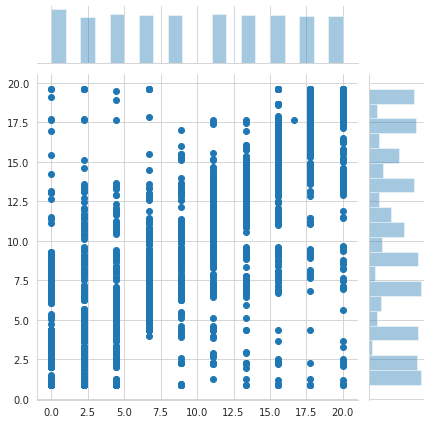

In [68]:
sns.jointplot(y_test, predictions)
plt.show()

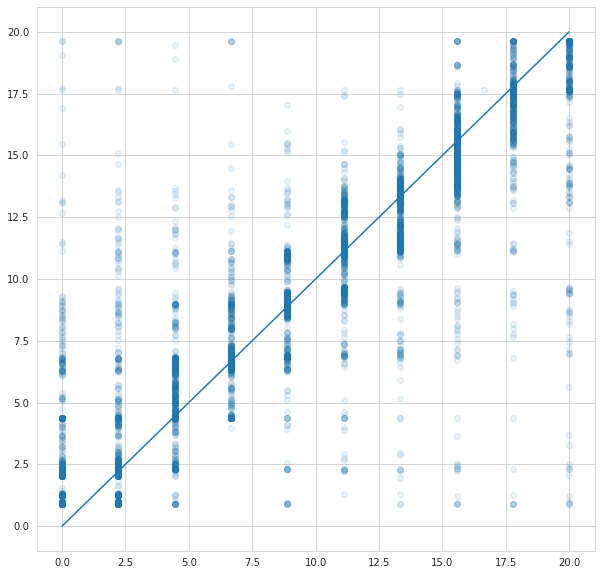

In [69]:
x = y_test
y = predictions.reshape(len(predictions))
plt.figure(figsize=(10,10))
plt.scatter(x,y,alpha=0.1)
plt.plot(np.arange(0,21),np.arange(0,21))
plt.show()

In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [25]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [3.31147218 2.91752976 3.07508386 3.11156829 3.0274129  3.0362428
 2.97228482 3.20310832 3.18102999 3.08836038]
Mean: 3.0924093294185253
Standard deviation: 0.11007816866725904


In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10,
                         n_jobs=16)

tree_rmse_scores = np.sqrt(-scores)

In [27]:
from sklearn.metrics import mean_squared_error

predictions = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

2.4590868518662443